In [1]:
import pandas as pd
import sklearn, math
from collections import OrderedDict
import skill_metrics as sm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.lines import Line2D
import xarray as xr
import geopandas as gpd
import glob
import rioxarray as rxr

In [3]:
# check long term mean monthly temperature for different dataset
base_path= r'D:\Santosh\WEM\del\SWAT_Projects\Gridded_data/'
# def function that takes path and process to yield clipped nc file 
def path_to_nc(path):
    try:
        nc= xr.open_dataset(path).sel(lat=slice(8, 19), lon=slice(100, 110))
    except:
        nc= xr.open_mfdataset(path).sel(lat=slice(8, 19), lon=slice(100, 110))

    return nc

era_tmax = (xr.open_dataset(glob.glob(base_path+'era**/*tmx*.nc')[0]).sel(lat=slice(8, 19), lon=slice(100, 110), time=slice('1992-01-01', '2014-12-31'))
            .rename({'tmx':'tmax'})
            .resample(time='M').mean()
           )
era_tmax

In [5]:
# readshape file of Tolne Sap basin
from shapely import speedups
speedups.disable()
tonlesap =gpd.read_file('./CMIP6/Cambodia/subs1.shp').to_crs('EPSG:4326')
# read Aphrodite
cam_tmax_nc = xr.open_dataset(glob.glob(base_path+'era**/*tmax*.nc')[0]).sel(lon=slice(100, 110), lat= slice(16, 10), time= slice('1985-01-01', '2014-12-31'))- 273.15 # to convert in degree centigrade
cam_tmax_projected= cam_tmax_nc.tmax.rio.set_crs(4326)
cam_tmax_clipped=cam_tmax_projected.rio.clip(tonlesap.geometry, all_touched=True)

In [6]:
#all_bcc_files = glob.glob('G:/CMIP6/BCC*/tasmax/*.nc')
models=['BCC-CSM2-MR','Canesm5','GFDL-CM4', 'MRI-CSM2-0']
scenarios=['historical','ssp245', 'ssp585']
scen_wise_file ={scenario:  glob.glob('G:/CMIP6/BCC*/tasmax/**{}*.nc'.format(scenario)) for scenario in scenarios}
len(scen_wise_file['historical'])

1

In [7]:
# try for one
# read all scenarios of bcc and concat in one xarray file
#function to preprocess datast
def pre_process(file, scenario, observed_data):
    #add leap year to gcm data by reindexing with pd date range
    
    if scenario=='historical':
        time= slice('1985-01-01', '2014-12-31')
        
    else: 
        time=slice('2015-01-01', '2100-12-31')
        #reindex_time=pd.date_range(start='2015-01-01', end='2100-12-31', freq='D')
    if len(file)==1:
        ds=xr.open_dataset(file[0]).tasmax.sel(time=time, lat=slice(8, 19), lon=slice(100, 110))
        
        regridded=ds.interp(lat=observed_data.lat, lon=observed_data.lon, method='linear')
        ds_clipped = regridded.rio.set_crs(4326)
        ds_clipped=ds_clipped.rio.clip(tonlesap.geometry, all_touched=True)#.expand_dims(dim='scenario')
        #print(ds_clipped)
    else:
        ds=xr.open_mfdataset(file).tasmax.sel(time=time,lat=slice(8, 19), lon=slice(100, 110))

        regridded=ds.interp(lat=observed_data.lat, lon=observed_data.lon, method='linear')
        ds_clipped = regridded.rio.set_crs(4326)
        ds_clipped=ds_clipped.rio.clip(tonlesap.geometry, all_touched=True)#.expand_dims(dim='scenario')
        
        #print(ds_clipped)
    # check for unit and apply correction factor if unit is not in mm   
    print(ds_clipped.units)
    if ds_clipped.units.startswith('K') or ds_clipped.units=='K':
       # print('I am here')
        ds_clipped= ds_clipped - 273.15
    else:
        ds_clipped=ds_clipped
   
    # remove leap year from all dataset
    ds_clipped= ds_clipped.sel(time=~((ds_clipped.time.dt.month==2)& (ds_clipped.time.dt.day==29)))
    try:
        ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()
    except:
        ds_clipped=ds_clipped


    return ds_clipped



# bias correction
def apply_corr(ds, c):
    corr_ds=[]
    for i in range(1, 13):
        corr_ds.append(ds.isel(time=(ds.time.dt.month==i))+c.sel(month=i))
    return xr.concat(corr_ds, dim='time')

# def function to process dataset and bias correct
def bias_correct(gcm_files, shp, obs):
    raw_ds={}
    corr_factor=[]
    corrected_ds={}
    #remove leap year data in observed file
    obs= obs.sel(time=~((obs.time.dt.month==2)& (obs.time.dt.day==29)))
    corrected_ds['observed']=obs
    raw_ds['observed']=obs
    # clip observed data with shape file
    #.assign_coords({'scenario':scenario})
    for scenario, file in gcm_files.items():
        print(file)
        processed_ds=pre_process(file, scenario, obs)
       
       
        raw_ds[scenario]=processed_ds#.drop('month')
        if scenario=='historical':
            correction_factor=obs.groupby('time.month').mean(skipna=True)-(processed_ds.groupby('time.month').mean(skipna=True))
           
            corr_factor.append(correction_factor)
        ds_corrected= apply_corr(processed_ds, corr_factor[0]).drop('month')
        try:
            ds_corrected['time']= ds_corrected.indexes['time'].to_datetimeindex()
        except:
            ds_corrected=ds_corrected
        corrected_ds[scenario]=ds_corrected#.to_dataset(name=scenario)#.squeeze('month')
        #print(corrected_ds)
    
    return raw_ds, corrected_ds#.to_array(dim='scenario'), xr.Dataset(corrected_ds).to_array(dim='scenario')  
    #return xr.concat(raw_ds.values(), dim='scenario'), xr.concat(corrected_ds.values(), dim='scenario')

In [8]:
scen_wise_file_allmodel={model: {scenario:  glob.glob('./CMIP6/{0}*/tasmax/**{1}*.nc'.format(model,scenario)) for scenario in scenarios} for model in models}
raw_model={}
corrected_model={}
for model, file in scen_wise_file_allmodel.items():
    raw_model[model], corrected_model[model] = bias_correct(file, tonlesap, cam_tmax_clipped)

['G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_historical_r1i1p1f1_gn_19750101-20141231.nc']
K


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


['G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_20900101-21001231.nc', 'G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_20650101-20891231.nc', 'G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_20400101-20641231.nc', 'G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_ssp245_r1i1p1f1_gn_20150101-20391231.nc']
K


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


['G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_20900101-21001231.nc', 'G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_20650101-20891231.nc', 'G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_20400101-20641231.nc', 'G:/CMIP6\\BCC-CSM2-MR\\tasmax\\tasmax_day_BCC-CSM2-MR_ssp585_r1i1p1f1_gn_20150101-20391231.nc']
K


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


['G:/CMIP6\\Canesm5\\tasmax\\tasmax_day_CanESM5_historical_r1i1p1f1_gn_18500101-20141231.nc']
K
['G:/CMIP6\\Canesm5\\tasmax\\tasmax_day_CanESM5_ssp245_r1i1p1f1_gn_20150101-21001231.nc']


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


K


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


['G:/CMIP6\\Canesm5\\tasmax\\tasmax_day_CanESM5_ssp585_r1i1p1f1_gn_21010101-21801231.nc', 'G:/CMIP6\\Canesm5\\tasmax\\tasmax_day_CanESM5_ssp585_r1i1p1f1_gn_20150101-21001231.nc']
K


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


['G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_18500101-18691231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_18700101-18891231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_18900101-19091231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_19100101-19291231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_19300101-19491231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_19500101-19691231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_19700101-19891231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_19900101-20091231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_historical_r1i1p1f1_gr1_20100101-20141231.nc']
K


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


['G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp245_r1i1p1f1_gr1_20150101-20341231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp245_r1i1p1f1_gr1_20350101-20541231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp245_r1i1p1f1_gr1_20550101-20741231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp245_r1i1p1f1_gr1_20750101-20941231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp245_r1i1p1f1_gr1_20950101-21001231.nc']
K


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


['G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp585_r1i1p1f1_gr1_20150101-20341231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp585_r1i1p1f1_gr1_20350101-20541231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp585_r1i1p1f1_gr1_20550101-20741231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp585_r1i1p1f1_gr1_20750101-20941231.nc', 'G:/CMIP6\\GFDL-CM4\\tasmax\\tasmax_day_GFDL-CM4_ssp585_r1i1p1f1_gr1_20950101-21001231.nc']
K


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\coding\times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
<ipython-input-7-b8e23e2bba97>:39: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_clipped['time']= ds_clipped.indexes['time'].to_datetimeindex()


['G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_historical_r1i1p1f1_gn_18500101-18991231.nc', 'G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_historical_r1i1p1f1_gn_19000101-19491231.nc', 'G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_historical_r1i1p1f1_gn_19500101-19991231.nc', 'G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_historical_r1i1p1f1_gn_20000101-20141231.nc']
K
['G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_20150101-20641231.nc', 'G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_ssp245_r1i1p1f1_gn_20650101-21001231.nc']
K
['G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_21010101-21501231.nc', 'G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_20150101-20641231.nc', 'G:/CMIP6\\MRI-CSM2-0\\tasmax\\tasmax_day_MRI-ESM2-0_ssp585_r1i1p1f1_gn_20650101-21001231.nc']
K


In [9]:
bias_tasmax=xr.Dataset(
    {model: gcm['historical'].groupby('time.year').mean(skipna=False).mean(dim='year') - 
              gcm['observed'].groupby('time.year').mean(skipna=False).mean(dim='year') 
                 for model, gcm in raw_model.items()}
).to_array('bias').compute()

c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [37]:
bias_tasmax.mean(dim=('lat','lon')).drop(['spatial_ref','height']).to_dataframe('bias')

,bias
bias,
BCC-CSM2-MR,-0.384831
Canesm5,-1.130038
GFDL-CM4,-2.463067
MRI-CSM2-0,-0.346656


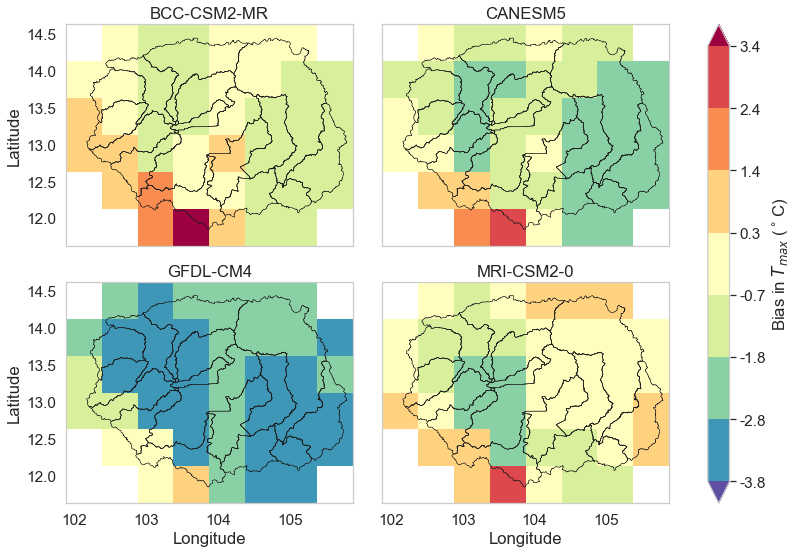

In [17]:
import seaborn as sns
# fig, axes= plt.subplots(2,2, figsize=(15,12))
tonlesap_new= tonlesap.set_crs(bias_tasmax.rio.crs)
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
fig=bias_tasmax.plot(col='bias', col_wrap=2, cmap='Spectral_r', levels=8, extend='both', 
              vmax=bias_tasmax.max(), vmin=bias_tasmax.min(),
          cbar_kwargs={'label':'Bias in $T_{max}$ ($^\circ$C)', 'format':'%.1f'}, figsize=(12,8))
[tonlesap_new.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=0.5) for ax in fig.axes.flatten()]
fig.set_axis_labels('Longitude', 'Latitude')
[ax.set_title(model.upper()) for ax, model in zip(fig.axes.flatten(), bias_tasmax.bias.values.tolist())]
#[ax.set_yticks([12, 12.5, 13, 13.5, 14, 14.5])]

plt.savefig('./Tmax Bias in GCMs.png', dpi=600 )

In [41]:
raw_sd_tasmax = xr.Dataset({model: np.std(gcm['historical'].resample(time='M').mean(skipna=False).mean(dim=('lat', 'lon')) )
              for model, gcm in raw_model.items()}
            ).to_array('models').drop(['height', 'spatial_ref']).to_dataframe('sd')
raw_sd_tasmax

,sd
models,
BCC-CSM2-MR,2.294647
Canesm5,2.687195
GFDL-CM4,2.775145
MRI-CSM2-0,2.788661


In [44]:
corr_sd_tasmax = xr.Dataset({model: np.std(gcm['historical'].interp_calendar(gcm['observed'].time).resample(time='M').mean(skipna=False).mean(dim=('lat', 'lon')) )
              for model, gcm in corrected_model.items()}
            ).to_array('models').drop(['height', 'spatial_ref']).to_dataframe('sd')
corr_sd_tasmax

c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\core\indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\core\indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,sd
models,
BCC-CSM2-MR,1.772121
Canesm5,1.794074
GFDL-CM4,1.931239
MRI-CSM2-0,1.991995


In [15]:
raw_tasmax_corr_coef = xr.Dataset({model: (xr.corr(gcm['observed'].resample(time='M').mean(skipna=False), 
                    gcm['historical'].resample(time='M').mean(skipna=False), dim='time'))**2
              for model, gcm in raw_model.items()}
            ).to_array('raw_corr')#.compute()

In [38]:
raw_tasmax_corr_coef.mean(dim=('lat','lon')).drop(['height','spatial_ref']).to_dataframe('r2')

c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,r2
raw_corr,
BCC-CSM2-MR,0.415171
Canesm5,0.509279
GFDL-CM4,0.424288
MRI-CSM2-0,0.423295


In [40]:
corr_tasmax_corr_coef = xr.Dataset({model: (xr.corr(gcm['observed'].resample(time='M').mean(skipna=False), 
                    gcm['historical'].interp_calendar(gcm['observed'].time).resample(time='M').mean(skipna=False), dim='time'))**2
              for model, gcm in corrected_model.items()}
            ).to_array('raw_corr')#.compute()
corr_tasmax_corr_coef.mean(dim=('lat','lon')).drop(['height','spatial_ref']).to_dataframe('r2')

c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\core\indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\core\indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,r2
raw_corr,
BCC-CSM2-MR,0.560516
Canesm5,0.552092
GFDL-CM4,0.460647
MRI-CSM2-0,0.444906


c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


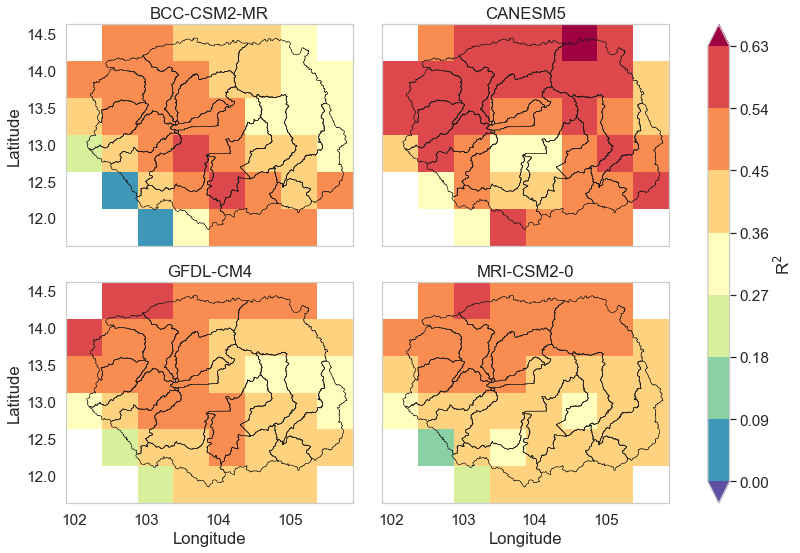

In [16]:
fig_raw_tasmax=raw_tasmax_corr_coef.plot(col='raw_corr', col_wrap=2, cmap='Spectral_r', levels=8, extend='both', 
              vmax=raw_tasmax_corr_coef.max(), vmin=raw_tasmax_corr_coef.min(),
          cbar_kwargs={'label':'R${^2}$', 'format':'%.2f'}, figsize=(12,8))
[tonlesap_new.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=0.5) for ax in fig_raw_tasmax.axes.flatten()]
fig_raw_tasmax.set_axis_labels('Longitude', 'Latitude')
[ax.set_title(model.upper()) for ax, model in zip(fig_raw_tasmax.axes.flatten(),raw_tasmax_corr_coef.raw_corr.values.tolist())]
plt.savefig('./Raw_data Monthly R2 for tasmax.png', dpi=600)

In [18]:
# calculate rmse
import xskillscore as xs
rmse_tasmax_raw= xr.Dataset({model:xs.rmse(gcm['observed'].resample(time='M').mean(skipna=False).compute(),
                    gcm['historical'].resample(time='M').mean(skipna=False).compute(), dim='time', skipna=False)
              for model, gcm in raw_model.items()}
            ).to_array('raw_rmse')#.compute()


# rmse_tasmax_raw= xr.Dataset({model:((gcm['observed'].resample(time='M').mean(skipna=False).mean(dim='time')-
#                     gcm['historical'].resample(time='M').mean(skipna=False).mean(dim='time'))**2)**(0.5)
#               for model, gcm in raw_model.items()}
#             ).to_array('raw_rmse').compute()
rmse_tasmax_raw

<xarray.DataArray (raw_rmse: 4, lat: 6, lon: 8)>
array([[[       nan, 1.98485358, 2.28323291, 2.43173716, 2.18872176,
         2.1870109 , 2.34875787,        nan],
        [2.0104269 , 2.07080999, 2.49211873, 2.45876137, 2.14609174,
         2.2017469 , 2.38926955, 2.58262664],
        [1.90573608, 1.86952467, 2.26514091, 2.04044758, 1.85331811,
         2.21567663, 2.34257648, 2.45789179],
        [2.23430471, 2.09107122, 2.01485111, 1.61015538, 1.58857095,
         1.88820752, 2.0449669 , 2.17490126],
        [       nan, 2.39754839, 2.30410151, 1.66971779, 1.45693353,
         1.83326139, 2.06922307, 1.80548048],
        [       nan,        nan, 2.8010174 , 3.70873957, 1.48171813,
         2.02098611, 1.94511834,        nan]],

       [[       nan, 2.29171166, 2.47196856, 2.39243541, 2.21026982,
         2.13028719, 2.32468572,        nan],
        [2.07498245, 2.35491723, 2.91481119, 2.75763631, 2.30569434,
         2.37099545, 2.75758034, 3.31830526],
        [1.82909053, 2.27916032, 2.87700452, 2.69083127, 2.30428767,
         2.61452566, 2.90737684, 3.2467852 ],
        [1.79961003, 1.63746934, 2.79940513, 2.55418657, 2.33259671,
...
         3.69876027, 3.64897323, 3.55855751],
        [2.22317266, 2.33832121, 4.33259153, 3.6210351 , 2.85479331,
         3.72997928, 3.6980238 , 3.6069715 ],
        [       nan, 2.13339639, 2.04680157, 3.57310557, 3.22189999,
         3.83304   , 3.97804046, 3.53544855],
        [       nan,        nan, 2.0388968 , 2.15915489, 2.62745023,
         4.03075075, 3.98608828,        nan]],

       [[       nan, 2.74391127, 2.74913645, 2.664608  , 2.36354852,
         2.17972064, 2.28124976,        nan],
        [2.65948081, 2.70429516, 3.01873207, 2.7593112 , 2.19319725,
         2.03599644, 2.10637283, 2.31855154],
        [2.46231771, 2.61798501, 3.17333555, 2.83049536, 2.13170886,
         2.14378595, 2.1112535 , 2.2205236 ],
        [2.44332552, 2.10893607, 3.3570478 , 2.8423965 , 2.00771737,
         2.24010873, 2.09866619, 2.19207239],
        [       nan, 2.13927746, 1.94432807, 2.76232886, 2.12323999,
         2.1847198 , 2.16670275, 2.13683748],
        [       nan,        nan, 2.24461031, 3.11542034, 1.89830995,
         2.3339622 , 2.25337887,        nan]]])
Coordinates:
  * lat          (lat) float64 14.38 13.88 13.38 12.88 12.38 11.88
  * lon          (lon) float64 102.1 102.6 103.1 103.6 104.1 104.6 105.1 105.6
    spatial_ref  int32 0
    height       float64 2.0
  * raw_rmse     (raw_rmse) <U11 'BCC-CSM2-MR' 'Canesm5' 'GFDL-CM4' 'MRI-CSM2-0'

In [45]:
rmse_tasmax_raw.drop(['spatial_ref','height']).mean(dim=('lat','lon')).to_dataframe('RMSE')

,RMSE
raw_rmse,
BCC-CSM2-MR,2.139699
Canesm5,2.517447
GFDL-CM4,3.380019
MRI-CSM2-0,2.406260


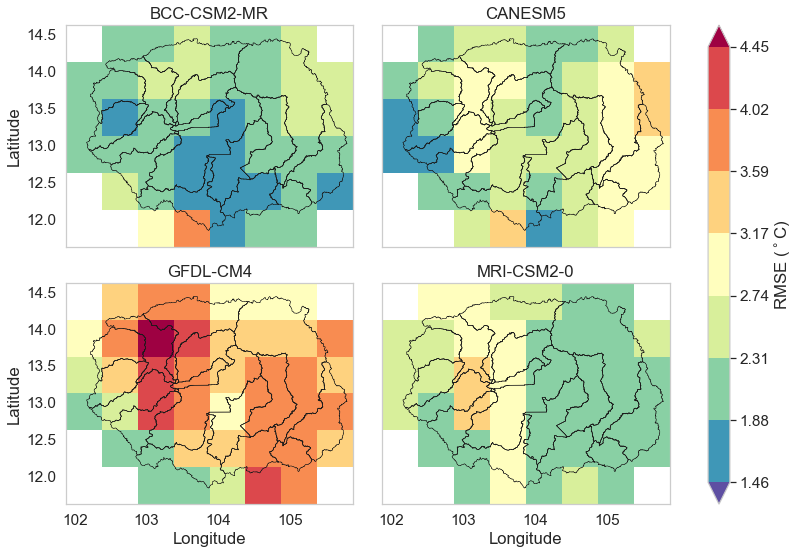

In [19]:
sns.set_style('whitegrid')
fig_rmse_tasmax=rmse_tasmax_raw.drop('height').plot(col='raw_rmse', col_wrap=2, cmap='Spectral_r', levels=8, extend='both', 
              vmin=rmse_tasmax_raw.min(), vmax=rmse_tasmax_raw.max(),
          cbar_kwargs={'label':'RMSE ($^\circ$C)', 'format':'%.2f'}, figsize=(12,8))
[tonlesap_new.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=0.5) for ax in fig_rmse_tasmax.axes.flatten()]
fig_rmse_tasmax.set_axis_labels('Longitude', 'Latitude')
[ax.set_title(model.upper()) for ax, model in zip(fig_rmse_tasmax.axes.flatten(),rmse_tasmax_raw.raw_rmse.values.tolist())]
plt.savefig('./RMSE for tasmax_xs.png', dpi=600)

In [20]:
# calculate rmse

rmse_tasmax_corr= xr.Dataset({model:xs.rmse(gcm['observed'].resample(time='M').mean(skipna=False).compute(),
                    gcm['historical'].interp_calendar(gcm['observed'].time).resample(time='M').mean(skipna=False).compute(), dim='time', skipna=True)             
                for model, gcm in corrected_model.items()}
            ).to_array('raw_rmse')
rmse_tasmax_corr

c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\core\indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\xarray\core\indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (raw_rmse: 4, lat: 6, lon: 8)>
array([[[       nan, 1.50387325, 1.47053553, 1.43025394, 1.35397392,
         1.32986109, 1.34282334,        nan],
        [1.34820944, 1.43318524, 1.46207571, 1.42731896, 1.34581982,
         1.33054648, 1.3300667 , 1.36872354],
        [1.2642284 , 1.35269118, 1.40420181, 1.37318298, 1.29212707,
         1.31735893, 1.2986522 , 1.34965083],
        [1.13178676, 1.23351605, 1.38859232, 1.30900891, 1.20805116,
         1.29018767, 1.29118348, 1.30146033],
        [       nan, 0.96574882, 1.20857277, 1.39340746, 1.27028298,
         1.24177842, 1.2557704 , 1.19979087],
        [       nan,        nan, 0.95165225, 1.05601696, 1.20528668,
         1.22087342, 1.15103835,        nan]],

       [[       nan, 1.58672319, 1.58810356, 1.59005462, 1.53795026,
         1.44623458, 1.3950231 ,        nan],
        [1.31961574, 1.41841565, 1.49168204, 1.48792754, 1.43941988,
         1.37618537, 1.33918163, 1.3197228 ],
        [1.20523037, 1.2790633 , 1.37208576, 1.3907452 , 1.35851082,
         1.35645922, 1.29481219, 1.31237651],
        [1.06989756, 1.16282482, 1.37375527, 1.31294811, 1.25297258,
...
         1.5330447 , 1.49687827, 1.53313255],
        [1.30694246, 1.4479444 , 1.66540611, 1.58905435, 1.47580957,
         1.51829183, 1.50018001, 1.49496078],
        [       nan, 1.2572006 , 1.57984149, 1.69124496, 1.58599091,
         1.53330755, 1.5117116 , 1.43576348],
        [       nan,        nan, 1.31102061, 1.35755825, 1.51470733,
         1.53159356, 1.44363558,        nan]],

       [[       nan, 1.7371887 , 1.7376796 , 1.74591327, 1.67542243,
         1.65749025, 1.65566862,        nan],
        [1.61202443, 1.66414142, 1.72684884, 1.70837247, 1.65428877,
         1.6727643 , 1.64761007, 1.64355791],
        [1.50973678, 1.56599343, 1.60937357, 1.61622524, 1.61928415,
         1.74533403, 1.67598379, 1.67259622],
        [1.37118769, 1.42778409, 1.56621313, 1.53149092, 1.55305386,
         1.84132266, 1.7382549 , 1.68973267],
        [       nan, 1.18846607, 1.41201162, 1.60749614, 1.56271791,
         1.67543447, 1.70028341, 1.65645719],
        [       nan,        nan, 1.1939429 , 1.31947076, 1.48339212,
         1.5858351 , 1.60108984,        nan]]])
Coordinates:
  * lat          (lat) float64 14.38 13.88 13.38 12.88 12.38 11.88
  * lon          (lon) float64 102.1 102.6 103.1 103.6 104.1 104.6 105.1 105.6
    spatial_ref  int32 0
    height       float64 2.0
  * raw_rmse     (raw_rmse) <U11 'BCC-CSM2-MR' 'Canesm5' 'GFDL-CM4' 'MRI-CSM2-0'

In [46]:
rmse_tasmax_corr.drop(['spatial_ref','height']).mean(dim=('lat','lon')).to_dataframe('RMSE')

,RMSE
raw_rmse,
BCC-CSM2-MR,1.295318
Canesm5,1.318810
GFDL-CM4,1.535451
MRI-CSM2-0,1.601408


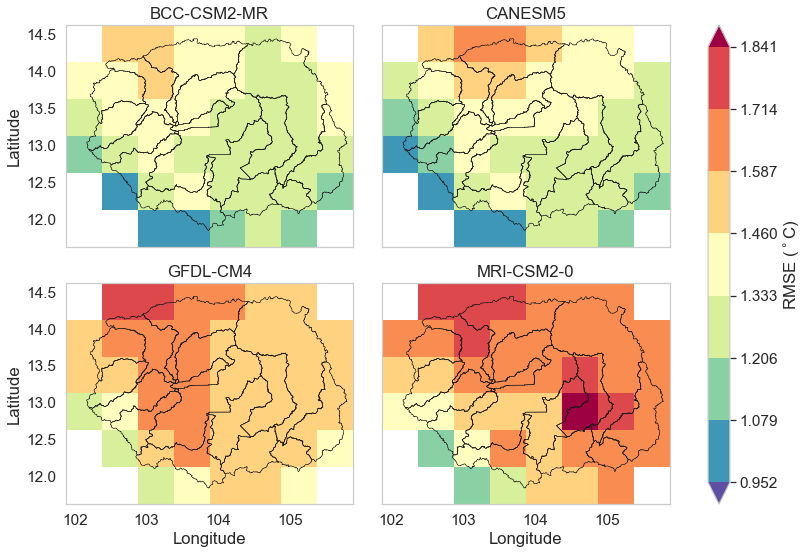

In [21]:
sns.set_style('whitegrid')
fig_rmse_tasmax_corr=rmse_tasmax_corr.drop('height').plot(col='raw_rmse', col_wrap=2, cmap='Spectral_r', levels=8, extend='both', 
              vmax=rmse_tasmax_corr.max(), vmin=rmse_tasmax_corr.min(),
          cbar_kwargs={'label':'RMSE ($^\circ$C)', 'format':'%.3f'}, figsize=(12,8))
[tonlesap_new.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=0.5) for ax in fig_rmse_tasmax_corr.axes.flatten()]
fig_rmse_tasmax_corr.set_axis_labels('Longitude', 'Latitude')
[ax.set_title(model.upper()) for ax, model in zip(fig_rmse_tasmax_corr.axes.flatten(),rmse_tasmax_corr.raw_rmse.values.tolist())]
plt.savefig('./RMSE of corrected GCM for tasmax_xs.png', dpi=600)


In [22]:
# calculate ensemble
swapped_tasmax={key:{k:corrected_model[k][key].compute() for k in corrected_model if key in corrected_model[k]} for key in scenarios}
#ensemble= {scen: fls.values().mean(dim=('lat','lon')) for scen, fls in swapped_s.}
swapped_tasmax

c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\users\pallav\appdata\local\programs\python\python39\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
c:\users\pallav\appdata\local\programs\python\pyth

{'historical': {'BCC-CSM2-MR': <xarray.DataArray (time: 10950, lat: 6, lon: 8)>
  array([[[        nan, 31.2742217 , 32.12806008, ..., 32.0079154 ,
           32.38451838,         nan],
          [32.77404395, 33.16557478, 33.81288623, ..., 33.35683302,
           33.83838559, 34.26045369],
          [32.56280149, 33.47059165, 33.90462199, ..., 34.09175005,
           34.33800695, 34.54647928],
          [32.21784742, 32.08790459, 33.70944684, ..., 33.69678309,
           34.04616709, 34.37263048],
          [        nan, 31.47014855, 30.40862904, ..., 33.45250775,
           34.20806896, 33.95436999],
          [        nan,         nan, 30.61627605, ..., 33.49726821,
           33.78202299,         nan]],
  
         [[        nan, 25.59611357, 26.85531828, ..., 26.81737409,
           26.50860049,         nan],
          [26.89157567, 27.56090855, 28.60819855, ..., 28.44119434,
           28.38561679, 28.27055477],
          [27.73930619, 28.83406291, 29.59996406, ..., 30.08250412,


In [56]:
swapped_tasmax['OBSERVED']= {'OBSERVED': corrected_model['BCC-CSM2-MR']['observed']}
all_model_df = pd.concat({scen: pd.concat({model: da.mean(dim=('lat','lon')).drop(['spatial_ref']).to_dataframe('tasmax') for model, da in gcms.items()}) for scen, gcms in swapped_tasmax.items()})
all_model_df.drop('height', axis=1).to_excel(r'./SiemReap_Cambodia/dailydatasets/tasmax_all_ds_daily_projection.xlsx')

In [23]:
#calculate ensemble
ens_tasmax= {scen: sum(gcm.values())/len(gcm.keys()) for scen, gcm in swapped_tasmax.items() }
ens_tasmax['observed']=corrected_model['BCC-CSM2-MR']['observed']
ens_tasmax

{'historical': <xarray.DataArray (time: 10950, lat: 6, lon: 8)>
 array([[[        nan, 28.44495388, 29.34722272, ..., 29.06844208,
          29.62094766,         nan],
         [29.65861919, 30.06222208, 30.7936963 , ..., 30.37221427,
          31.02511329, 31.61853259],
         [29.48848799, 30.40170443, 30.96414472, ..., 31.48433586,
          31.82777993, 32.13343369],
         [29.24927076, 29.07574851, 30.81938708, ..., 31.4666465 ,
          31.89008436, 32.29061019],
         [        nan, 29.04600352, 27.80805832, ..., 31.31342165,
          32.26929428, 32.21590817],
         [        nan,         nan, 28.30951906, ..., 31.45689395,
          32.0597095 ,         nan]],
 
        [[        nan, 26.16501034, 27.23065978, ..., 27.71712021,
          28.08908026,         nan],
         [27.25333495, 27.87275376, 28.8561783 , ..., 29.25435045,
          29.72648466, 30.13913915],
         [27.32208561, 28.49740229, 29.35200902, ..., 30.64601803,
          30.86359845, 31.04338857

In [51]:
ens_tasmax_df= pd.concat({scen: ds.mean(dim=('lat','lon')).to_dataframe('tmax') for scen,ds in ens_tasmax.items()}, axis=0).drop(['height', 'spatial_ref'], axis=1)
ens_tasmax_df

tmax
           time                          
historical 1985-01-01 12:00:00  30.214733
           1985-01-02 12:00:00  28.985272
           1985-01-03 12:00:00  29.285923
           1985-01-04 12:00:00  30.141297
           1985-01-05 12:00:00  30.134745
...                                   ...
observed   2014-12-27 00:00:00  32.241047
           2014-12-28 00:00:00  31.044167
           2014-12-29 00:00:00  28.738087
           2014-12-30 00:00:00  28.865257
           2014-12-31 00:00:00  28.817867

[84680 rows x 1 columns]

In [25]:
ens_tasmax_wohist= ens_tasmax_df[ens_tasmax_df.index.get_level_values(0)!='historical']
ens_tasmax_wohist.index =ens_tasmax_wohist.index.set_levels([ens_tasmax_wohist.index.levels[0], pd.to_datetime(ens_tasmax_wohist.index.levels[1])])
ens_tasmax_wohist

tmax
         time                          
ssp245   2015-01-01 12:00:00  27.869457
         2015-01-02 12:00:00  28.036965
         2015-01-03 12:00:00  27.213494
         2015-01-04 12:00:00  27.415811
         2015-01-05 12:00:00  28.136897
...                                 ...
observed 2014-12-27 00:00:00  32.241047
         2014-12-28 00:00:00  31.044167
         2014-12-29 00:00:00  28.738087
         2014-12-30 00:00:00  28.865257
         2014-12-31 00:00:00  28.817867

[73730 rows x 1 columns]

In [48]:
# yearly data
ens_tasmax_wohist_yr= ens_tasmax_wohist.groupby([
    pd.Grouper(level=0),
    pd.Grouper(level='time', freq='Y')
]).mean()
ens_tasmax_wohist_yr['year']=ens_tasmax_wohist_yr.index.get_level_values(1).year
ens_tasmax_wohist_yr

tmax  year
         time                       
observed 1985-12-31  30.566688  1985
         1986-12-31  30.626378  1986
         1987-12-31  31.377788  1987
         1988-12-31  30.929413  1988
         1989-12-31  31.023115  1989
...                        ...   ...
ssp585   2096-12-31  35.403990  2096
         2097-12-31  35.755798  2097
         2098-12-31  35.551634  2098
         2099-12-31  35.228487  2099
         2100-12-31  36.152368  2100

[202 rows x 2 columns]

['observed', 'ssp245', 'ssp585']
1 slice('2015-01-01', '2044-12-31', None)
2 slice('2045-01-01', '2074-12-31', None)
3 slice('2075-01-01', '2100-12-31', None)


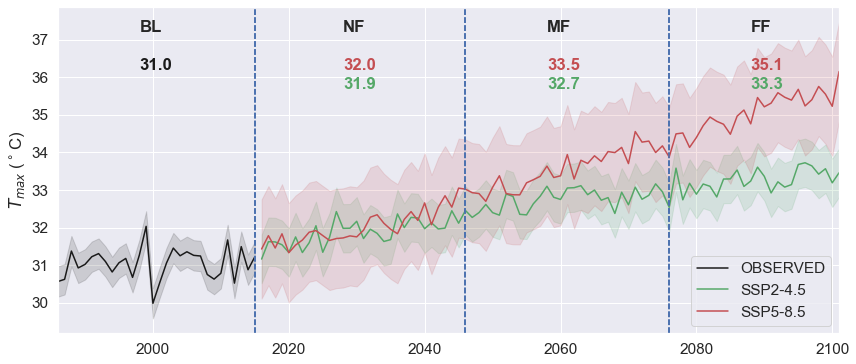

In [36]:
# make line plots
sns.set_style('darkgrid')
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
fig, ax = plt.subplots(1, figsize=(14, 6))
plt_df = ens_tasmax_wohist_yr.copy().dropna(True)
plt_scens = plt_df.index.get_level_values(0).unique().to_list()
print(plt_scens)
texts=['BL', 'NF', 'MF','FF']
plt_scs =['OBSEVED', 'SSP2-4.5', 'SSP5-8.5']
handles=[]
plt_colors=['k', 'g','r']
for i, sc in enumerate(plt_scens):
    line=ax.plot(plt_df.xs(sc).index, plt_df.xs(sc).tmax, color=plt_colors[i])
    handles.append(line)
    sd= np.std(plt_df.xs(sc))
    ax.fill_between(plt_df.xs(sc).index, (plt_df.xs(sc)+sd).tmax, (plt_df.xs(sc)-sd).tmax, color= plt_colors[i], alpha=0.15)
    ax.set_ylabel('$T_{max}$ ($^\circ$C)')
    ax.axvline(x=plt_df.xs('observed').index[29], linestyle='--', color='b')
    ax.axvline(x=plt_df.xs('ssp245').index[30], linestyle='--', color='b')
    ax.axvline(x=plt_df.xs('ssp245').index[60], linestyle='--', color='b')
    ax.set_xlim(plt_df.xs('observed').index.min(), plt_df.xs('ssp245').index.max())
   
    #ax.legend(line, plt_scs[i])
plt.legend(handles=[item for sublist in handles for item in sublist], labels=['OBSERVED', 'SSP2-4.5','SSP5-8.5'], loc=4)

j=12
times=[slice('1985-01-01','2014-12-31'), slice('2015-01-01','2044-12-31'), slice('2045-01-01','2074-12-31'), slice('2075-01-01','2100-12-31')]
for i, txt in enumerate(texts):

    if i==0:
        ax.text(plt_df.xs('observed').index[j], 37.2, s= texts[i], fontweight='bold') 
        ax.text(plt_df.xs('observed').index[j], 36.2, s=round(plt_df.xs('observed').tmax.mean(),0), color='k', fontweight='bold')
    else:
        ax.text(plt_df.xs('ssp245').index[j], 37.2, s= texts[i], fontweight='bold') 
        print(i,times[i])
        ax.text(plt_df.xs('ssp585').index[j], 36.2, s=round(plt_df.xs('ssp585').loc[times[i]].tmax.mean(),1), color='r',  fontweight='bold')
        ax.text(plt_df.xs('ssp245').index[j], 35.7, s=round(plt_df.xs('ssp245').loc[times[i]].tmax.mean(),1), color='g',  fontweight='bold')
        
        j=j+30

plt.savefig('./tmax annual longterm plot.png', dpi=600)      

In [247]:
plt_df.xs('observed').index.year

Int64Index([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
            1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
            2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
           dtype='int64', name='time')